<a href="https://colab.research.google.com/github/AnandSinhaProjects/BRAIN_RESEARCH/blob/main/Code/p1/Transfer_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 2.7 MB/s 


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import pydicom
import numpy as np
import shutil
from PIL import Image
import scipy
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import models , datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

print("Done!")

Done!


In [3]:
!pip install -p kaggle


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -p


In [13]:
! cp kaggle.json ~/.kaggle/

In [14]:
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-09-03 10:07:19          11840  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           7200  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2810  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2844  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [16]:
! kaggle datasets download -d abhranta/png-dataset-for-rsna-mgmt-detection

 99% 565M/573M [00:04<00:00, 104MB/s] 
100% 573M/573M [00:04<00:00, 122MB/s]


In [17]:
! unzip png-dataset-for-rsna-mgmt-detection.zip -d /content/rsna

Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-13.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-14.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-15.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-16.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-17.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-18.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-19.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-2.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-20.png  
  inflating: /content/rsna/png_data/png_voxel_converted_ds/train/00804/T1w/Image-21.png  
  inflating: /content/rsna/png_data/png_voxel_conv

In [18]:
! ls '/content/rsna/png_data/png_voxel_converted_ds/train'

00000  00085  00160  00240  00312  00390  00470  00549	00615  00694  00782
00002  00087  00162  00241  00313  00391  00472  00550	00616  00697  00784
00003  00088  00165  00242  00314  00392  00477  00551	00618  00698  00787
00005  00089  00166  00243  00316  00395  00478  00552	00619  00703  00788
00006  00090  00167  00245  00317  00397  00479  00554	00620  00704  00789
00008  00094  00169  00246  00318  00399  00480  00555	00621  00705  00791
00009  00095  00170  00247  00320  00400  00481  00556	00622  00706  00792
00011  00096  00171  00249  00321  00401  00483  00557	00623  00707  00793
00012  00097  00172  00250  00322  00402  00485  00558	00624  00708  00794
00014  00098  00176  00251  00324  00403  00488  00559	00625  00714  00795
00017  00099  00177  00253  00325  00404  00491  00561	00626  00715  00796
00018  00100  00178  00254  00327  00405  00493  00563	00628  00716  00797
00019  00102  00183  00258  00328  00406  00494  00564	00630  00718  00799
00020  00104  00184  0025

In [19]:
!mkdir "data"
!mkdir "data/0"
!mkdir "data/1"
labels = pd.read_csv("/content/rsna/png_data/png_voxel_converted_ds/train_labels.csv")

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/0’: File exists
mkdir: cannot create directory ‘data/1’: File exists


In [20]:
main_folder_path = "/content/rsna/png_data/png_voxel_converted_ds"

In [21]:
main_train_folder_path = os.path.join(main_folder_path, "train")
for subject in tqdm(os.listdir(main_train_folder_path)):
  subject_folder = os.path.join(main_train_folder_path , subject)
  for mri_type in os.listdir(subject_folder):
    mri_type_folder = os.path.join(subject_folder, mri_type)
    for mri_image in os.listdir(mri_type_folder):
      orignal_image_path = os.path.join(mri_type_folder, mri_image)
      mri_image = subject + "_" + mri_type + "_" + mri_image
      subject_num = int(subject)
      idx=np.where(labels['BraTS21ID']== subject_num)[0][0]
      label = str(labels.loc[idx, 'MGMT_value'])
      new_image_folder_path = os.path.join("data", label)
      new_image_path = os.path.join(new_image_folder_path, mri_image)
      shutil.copy(orignal_image_path, new_image_path)

  0%|          | 0/582 [00:00<?, ?it/s]

In [22]:
print("Images with label 0 = " , len(os.listdir("data/0")) , "Images with label 1 = " , len(os.listdir("data/1")))

Images with label 0 =  39744 Images with label 1 =  44064


In [23]:
for folder in os.listdir("data"):
    folder_name = str(folder)
    path = "data/"+folder_name
    for file in tqdm(os.listdir(path)):
        img = Image.open(path + '/' + file)
        clrs = img.getcolors()
        if len(clrs) == 1:
            os.remove(path + '/' + file)

  0%|          | 0/44064 [00:00<?, ?it/s]

  0%|          | 0/39744 [00:00<?, ?it/s]

In [24]:
print("Images with label 0 = " , len(os.listdir("data/0")) , "Images with label 1 = " , len(os.listdir("data/1")))

Images with label 0 =  31324 Images with label 1 =  34108


In [25]:
!mkdir "data/TRAIN"
!mkdir "data/TRAIN/1"
!mkdir "data/TRAIN/0"
!mkdir "data/VAL"
!mkdir "data/VAL/0"
!mkdir "data/VAL/1"
!mkdir "data/TEST"
!mkdir "data/TEST/0"
!mkdir "data/TEST/1"

In [26]:
IMG_PATH = "./data"

for CLASS in tqdm(["0", "1"]):
  IMG_NUM = len(os.listdir(IMG_PATH + "/" + CLASS))
  for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/' + CLASS)):
    img = IMG_PATH+ '/' + CLASS + '/' + FILE_NAME
    if n<4000 :
      shutil.copy(img, 'data/TEST/' + str(CLASS) + '/' + FILE_NAME)
    elif n<0.9*IMG_NUM:
      shutil.copy(img, 'data/TRAIN/' + str(CLASS) + '/' + FILE_NAME)
    else:
      shutil.copy(img, 'data/VAL/' + str(CLASS) + '/' + FILE_NAME)


  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
!rm -rf "data/0"
!rm -rf "data/1"

In [28]:
len(os.listdir("data/TRAIN/1")) , len(os.listdir("data/TRAIN/0")) , len(os.listdir("data/VAL/1")) , len(os.listdir("data/VAL/0")) , len(os.listdir("data/TEST/1")) , len(os.listdir("data/TEST/0"))

(26698, 24192, 3410, 3132, 4000, 4000)

In [29]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'TRAIN' : transforms.Compose([
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
    ]),

    'VAL' : transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
    ]),

    'TEST' : transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
    ]),
}

In [30]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TRAIN', 'VAL' , 'TEST']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['TRAIN', 'VAL' , 'TEST']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL' , 'TEST']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['0', '1']


In [31]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

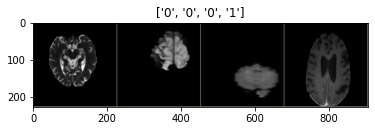

In [32]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN' , 'VAL']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            elif phase == 'VAL':
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'TRAIN':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'VAL' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #save the best model
                torch.save(model , model_name+'weights.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

In [ ]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
alexnet.classifier[6] = nn.Linear(num_ftrs,2)

alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(alexnet.parameters(), lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(alexnet ,"alexnet", criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TRAIN Loss: 0.6938 Acc: 0.5209
VAL Loss: 0.6901 Acc: 0.5229

Epoch 1/19
----------
TRAIN Loss: 0.6907 Acc: 0.5291
VAL Loss: 0.6897 Acc: 0.5280

Epoch 2/19
----------
TRAIN Loss: 0.6901 Acc: 0.5314
VAL Loss: 0.6882 Acc: 0.5327

Epoch 3/19
----------
TRAIN Loss: 0.6897 Acc: 0.5338
VAL Loss: 0.6878 Acc: 0.5312

Epoch 4/19
----------
TRAIN Loss: 0.6880 Acc: 0.5380
VAL Loss: 0.6856 Acc: 0.5463

Epoch 5/19
----------
TRAIN Loss: 0.6876 Acc: 0.5411
VAL Loss: 0.6856 Acc: 0.5382

Epoch 6/19
----------
TRAIN Loss: 0.6868 Acc: 0.5433
VAL Loss: 0.6857 Acc: 0.5426

Epoch 7/19
----------
TRAIN Loss: 0.6848 Acc: 0.5505
VAL Loss: 0.6833 Acc: 0.5567

Epoch 8/19
----------
TRAIN Loss: 0.6835 Acc: 0.5523
VAL Loss: 0.6830 Acc: 0.5581

Epoch 9/19
----------
TRAIN Loss: 0.6831 Acc: 0.5529
VAL Loss: 0.6816 Acc: 0.5538

Epoch 10/19
----------
TRAIN Loss: 0.6831 Acc: 0.5557
VAL Loss: 0.6815 Acc: 0.5556

Epoch 11/19
----------
TRAIN Loss: 0.6814 Acc: 0.5566
VAL Loss: 0.6817 Acc: 0.5627

Epoch 12/19
----------
T

In [34]:
vgg = models.vgg11_bn(pretrained=True)
num_ftrs = vgg.classifier[6].in_features

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [35]:
vgg.classifier[6] = nn.Linear(num_ftrs,2)

vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(vgg.parameters(), lr=0.001)

In [36]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(vgg,"vgg", criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TRAIN Loss: 0.6962 Acc: 0.5157
VAL Loss: 0.6890 Acc: 0.5434

Epoch 1/19
----------
TRAIN Loss: 0.6914 Acc: 0.5268
VAL Loss: 0.6891 Acc: 0.5410

Epoch 2/19
----------
TRAIN Loss: 0.6896 Acc: 0.5347
VAL Loss: 0.6845 Acc: 0.5443

Epoch 3/19
----------
TRAIN Loss: 0.6873 Acc: 0.5446
VAL Loss: 0.6850 Acc: 0.5489

Epoch 4/19
----------
TRAIN Loss: 0.6879 Acc: 0.5398
VAL Loss: 0.6803 Acc: 0.5605

Epoch 5/19
----------
TRAIN Loss: 0.6852 Acc: 0.5504
VAL Loss: 0.6818 Acc: 0.5573

Epoch 6/19
----------
TRAIN Loss: 0.6842 Acc: 0.5519
VAL Loss: 0.6799 Acc: 0.5631

Epoch 7/19
----------
TRAIN Loss: 0.6826 Acc: 0.5537
VAL Loss: 0.6766 Acc: 0.5680

Epoch 8/19
----------
TRAIN Loss: 0.6809 Acc: 0.5608
VAL Loss: 0.6750 Acc: 0.5714

Epoch 9/19
----------
TRAIN Loss: 0.6798 Acc: 0.5653
VAL Loss: 0.6758 Acc: 0.5708

Epoch 10/19
----------
TRAIN Loss: 0.6792 Acc: 0.5643
VAL Loss: 0.6742 Acc: 0.5735

Epoch 11/19
----------
TRAIN Loss: 0.6792 Acc: 0.5639
VAL Loss: 0.6736 Acc: 0.5746

Epoch 12/19
----------
T

In [37]:
vgg16= models.vgg16_bn(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [1]:
vgg16.classifier[6] = nn.Linear(num_ftrs,2)

vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16.parameters, lr=0.001)

NameError: ignored

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(vgg16,"vgg16", criterion, optimizer, step_lr_scheduler, num_epochs=20)

In [ ]:
vgg19 = models.vgg19_bn(pretrained=True)
num_ftrs = vgg19.classifier[6].in_features

In [ ]:
vgg19.classifier[6] = nn.Linear(num_ftrs,2)

vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg19.parameters, lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(vgg19,"vgg19", criterion, optimizer, step_lr_scheduler, num_epochs=20)

In [ ]:
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.classifier[6].in_features

In [ ]:
resnet18.classifier[6] = nn.Linear(num_ftrs,2)

resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18.parameters, lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(resnet18,"resnet18", criterion, optimizer, step_lr_scheduler, num_epochs=20)

In [ ]:
resnext101 = models.resnext101_32x8d(pretrained=True)
num_ftrs = resnext101.classifier[6].in_features

In [ ]:
resnext101.classifier[6] = nn.Linear(num_ftrs, 2)

resnext101 = resnext101.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnext101.parameters, lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(resnext101,"resnext101", criterion, optimizer, step_lr_scheduler, num_epochs=20)

In [ ]:
wide_resnet101 = models.wide_resnet101_2(pretrained=True)
num_ftrs = wide_resnet101.classifier[6].in_features

In [ ]:
wide_resnet101.classifier[6] = nn.Linear(num_ftrs,2)

wide_resnet101 = wide_resnet101.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(wide_resnet101.parameters, lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(wide_resnext101,"wide_resnext101", criterion, optimizer, step_lr_scheduler, num_epochs=20)

In [11]:
! nvidia-smi

Wed Sep  8 18:20:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------